In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Execution done using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Execution done Using MPS")
else:
    device = torch.device("cpu")
    print("Execution done Using CPU")
#cnn architecture
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        
        return out

# architecture of ResNet-34 Model
class ResNet34(nn.Module):
    def __init__(self, block, layers, num_classes=102): #num_classes is set to 102 due to the labelling
        super(ResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # designing ResNet layers according to [3, 4, 6, 3] configuration for ResNet-34
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# Instantiating the ResNet-34 model as model_res
model_res = ResNet34(BasicBlock, [3, 4, 6, 3], num_classes=102).to(device)


Execution done Using MPS


In [2]:
import scipy.io
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# Loading the  labels from the given imagelabels.mat files
label_file_path = 'imagelabels.mat'  # Replace with actual path
labels = scipy.io.loadmat(label_file_path)['labels'][0]

# Loading the  image paths
image_folder_path = 'jpg'  # Replace with actual path
image_paths = [os.path.join(image_folder_path, f'image_{i+1:05d}.jpg') for i in range(len(labels))]


In [3]:
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx] - 1  # Assuming labels start from 1, convert to 0-based indexing

        
        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
# Defining the train and test  transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=(5,9),sigma=(0.1,5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = FlowerDataset(image_paths=image_paths, labels=labels, transform=train_transform)

# Splitting the dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1* len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# validation and test transforms
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Creating train,validaton and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


In [5]:
import torch.optim as optim
import time
from tqdm import tqdm

#loss function, optimizer, and learning rate scheduler
criterion_res = nn.CrossEntropyLoss()
optimizer_res= optim.Adam(model_res.parameters(), lr=0.001)
scheduler_res = optim.lr_scheduler.StepLR(optimizer_res, step_size=3, gamma=0.1)
def train_model_res(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    total_training_time = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()  # Start time for the epoch
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training the model
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # calculating training loss and accuracy of our model
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate average training loss and accuracy of our model
        train_loss = running_loss / len(train_loader)
        train_accuracy = (correct / total)*100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        val_loss, val_accuracy = evaluate_model_res(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step()


        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        total_training_time += epoch_duration

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
              f"Epoch Duration: {epoch_duration:.2f} seconds")

    print(f"Total training time: {total_training_time:.2f} seconds")
    return train_losses, train_accuracies, val_losses, val_accuracies

# Validation function
def evaluate_model_res(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct / total)*100
    return avg_val_loss, val_accuracy

train_losses_res, train_accuracies_res, valid_losses_res, valid_accuracies_res = train_model_res(
    model_res, train_loader, val_loader, criterion_res, optimizer_res, scheduler_res, epochs=11)


Training Epoch 1/11: 100%|████████████████████| 205/205 [03:23<00:00,  1.01it/s]


Epoch [1/11], Train Loss: 4.1067, Train Accuracy: 8.00%, Val Loss: 3.7059, Val Accuracy: 11.61%, Epoch Duration: 211.28 seconds


Training Epoch 2/11: 100%|████████████████████| 205/205 [02:44<00:00,  1.24it/s]


Epoch [2/11], Train Loss: 3.4536, Train Accuracy: 14.78%, Val Loss: 3.4640, Val Accuracy: 15.65%, Epoch Duration: 172.64 seconds


Training Epoch 3/11: 100%|████████████████████| 205/205 [03:01<00:00,  1.13it/s]


Epoch [3/11], Train Loss: 3.1386, Train Accuracy: 19.69%, Val Loss: 3.1231, Val Accuracy: 20.78%, Epoch Duration: 189.57 seconds


Training Epoch 4/11: 100%|████████████████████| 205/205 [02:59<00:00,  1.14it/s]


Epoch [4/11], Train Loss: 2.6879, Train Accuracy: 29.05%, Val Loss: 2.5688, Val Accuracy: 31.54%, Epoch Duration: 187.33 seconds


Training Epoch 5/11: 100%|████████████████████| 205/205 [03:03<00:00,  1.12it/s]


Epoch [5/11], Train Loss: 2.5180, Train Accuracy: 32.77%, Val Loss: 2.4730, Val Accuracy: 34.35%, Epoch Duration: 191.23 seconds


Training Epoch 6/11: 100%|████████████████████| 205/205 [02:47<00:00,  1.23it/s]


Epoch [6/11], Train Loss: 2.3900, Train Accuracy: 34.85%, Val Loss: 2.3445, Val Accuracy: 35.09%, Epoch Duration: 172.49 seconds


Training Epoch 7/11: 100%|████████████████████| 205/205 [01:41<00:00,  2.02it/s]


Epoch [7/11], Train Loss: 2.2334, Train Accuracy: 39.54%, Val Loss: 2.2581, Val Accuracy: 38.63%, Epoch Duration: 106.66 seconds


Training Epoch 8/11: 100%|████████████████████| 205/205 [01:41<00:00,  2.01it/s]


Epoch [8/11], Train Loss: 2.1856, Train Accuracy: 40.45%, Val Loss: 2.2378, Val Accuracy: 38.63%, Epoch Duration: 107.04 seconds


Training Epoch 9/11: 100%|████████████████████| 205/205 [01:46<00:00,  1.92it/s]


Epoch [9/11], Train Loss: 2.1625, Train Accuracy: 41.23%, Val Loss: 2.2172, Val Accuracy: 39.24%, Epoch Duration: 112.03 seconds


Training Epoch 10/11: 100%|███████████████████| 205/205 [01:41<00:00,  2.01it/s]


Epoch [10/11], Train Loss: 2.1254, Train Accuracy: 41.92%, Val Loss: 2.2104, Val Accuracy: 39.61%, Epoch Duration: 107.09 seconds


Training Epoch 11/11: 100%|███████████████████| 205/205 [01:41<00:00,  2.02it/s]


Epoch [11/11], Train Loss: 2.1225, Train Accuracy: 42.30%, Val Loss: 2.2125, Val Accuracy: 39.00%, Epoch Duration: 106.81 seconds
Total training time: 1664.18 seconds


In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_res(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)*100
    print(f"Test Accuracy: {accuracy :.2f}%")

    # Calculating precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    print(f"Precision: {precision*100:.4f}")
    print(f"Recall: {recall*100:.4f}")
    print(f"F1 Score: {f1*100:.4f}")

    return all_labels,all_predictions,accuracy, precision, recall, f1

all_labels_res,all_predictions_res,test_accuracy_res, test_precision_res, test_recall_res, f1_score_res = evaluate_res(model_res, test_loader)


Test Accuracy: 39.88%
Precision: 34.6320
Recall: 35.5549
F1 Score: 32.3435


/Users/sathvicpuchalapalli/Desktop/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


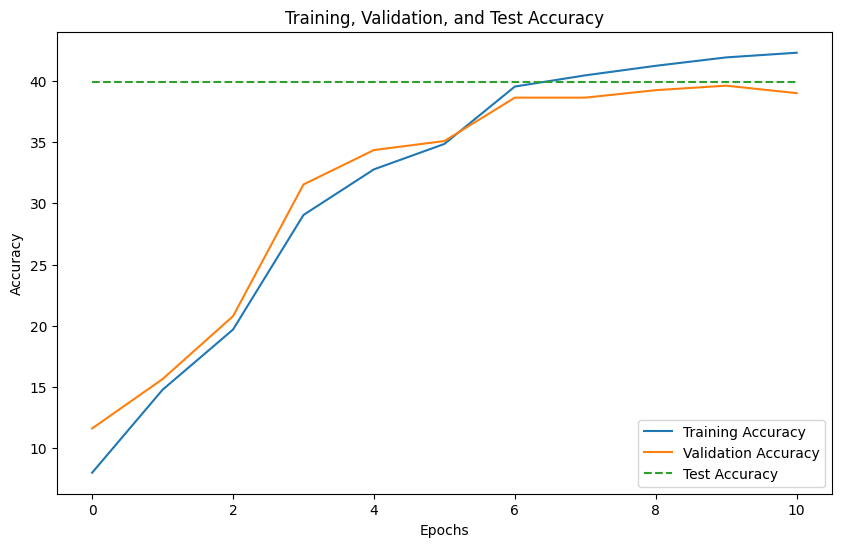

In [7]:
import matplotlib.pyplot as plt
test_accuracies_res = [test_accuracy_res] * len(train_accuracies_res)

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_res, label='Training Accuracy')
plt.plot(valid_accuracies_res, label='Validation Accuracy')
plt.plot(test_accuracies_res, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


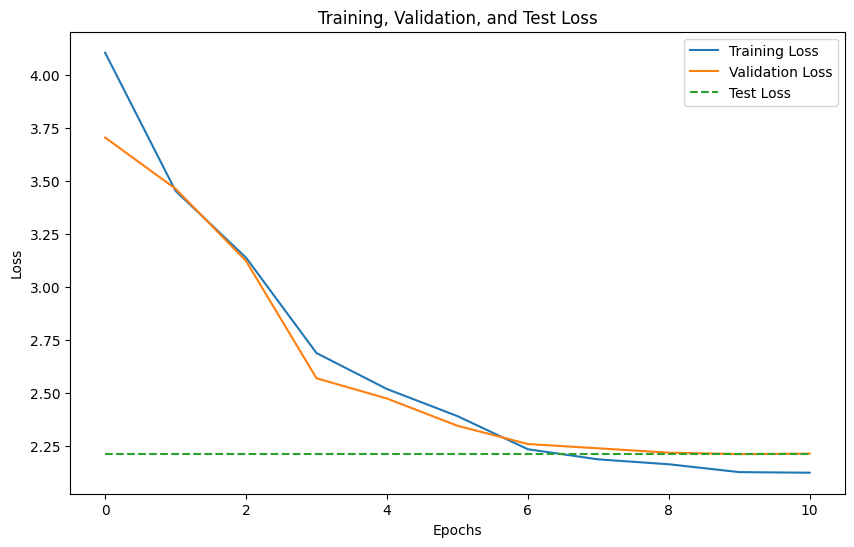

In [8]:
test_losses_res = [valid_losses_res[-1]] * len(train_losses_res)

# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses_res, label='Training Loss')
plt.plot(valid_losses_res, label='Validation Loss')
plt.plot(test_losses_res, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


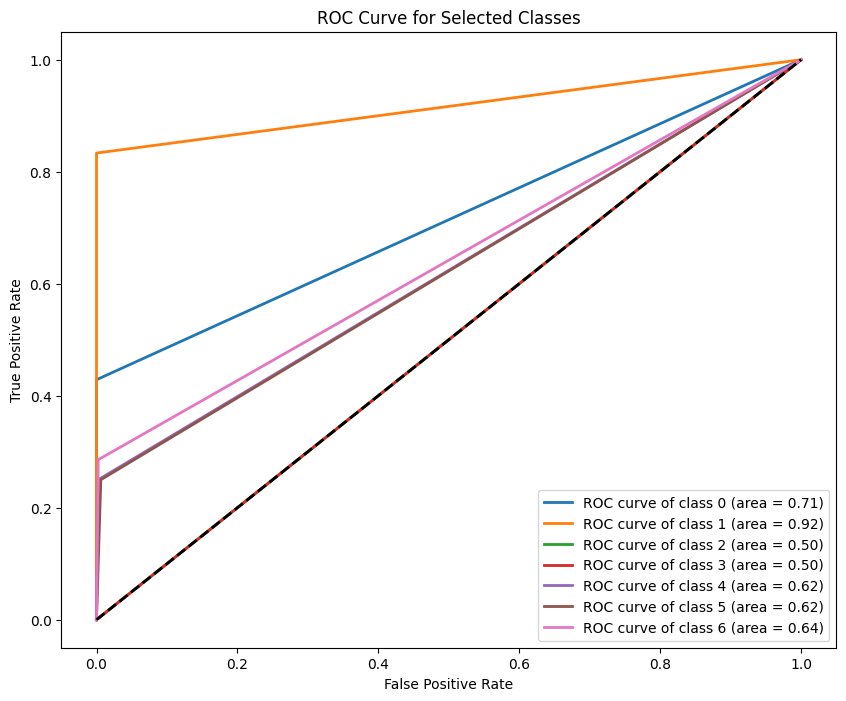

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

all_labels_b = label_binarize(all_labels_res, classes=range(102))
all_predictions_b = label_binarize(all_predictions_res, classes=range(102))

# Plot ROC curve for a 7 selected classes
plt.figure(figsize=(10, 8))
for i in range(7):
    fpr, tpr, _ = roc_curve(all_labels_b[:, i], all_predictions_b[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Selected Classes')
plt.legend(loc="lower right")
plt.show()


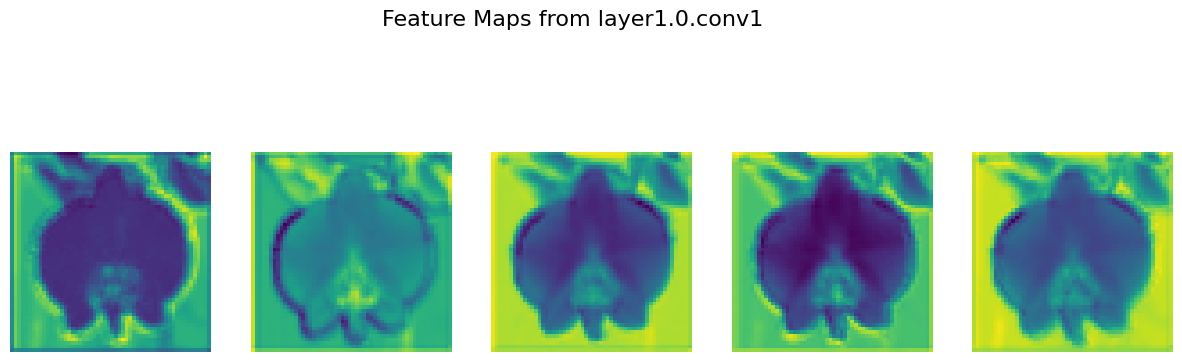

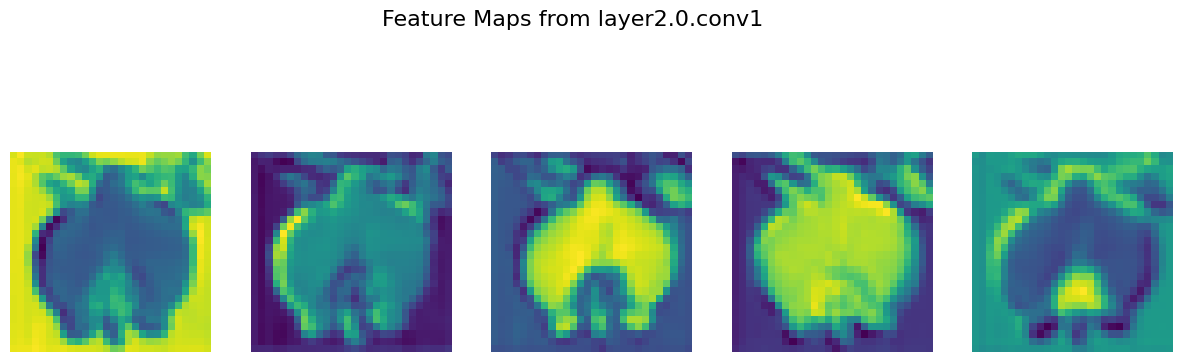

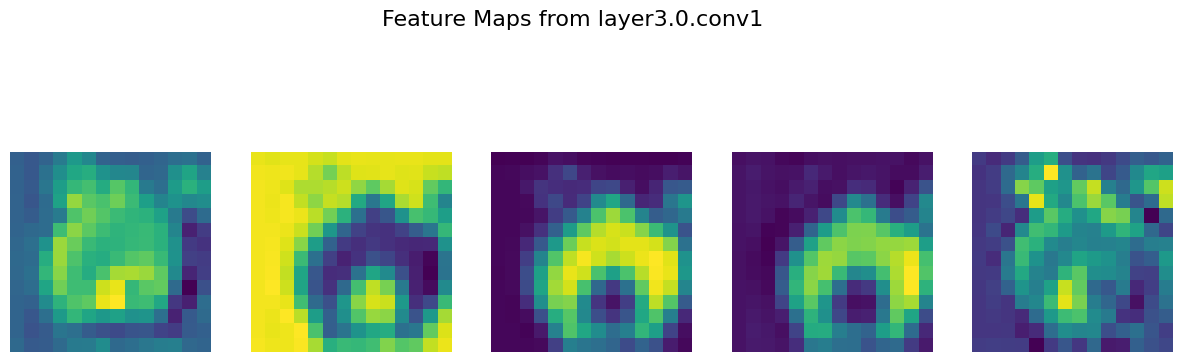

In [20]:
import matplotlib.pyplot as plt

feature_maps = {}

def get_feature_maps(name):
    def hook(model, input, output):
        feature_maps[name] = output
    return hook
layer_n = ['layer1.0.conv1', 'layer2.0.conv1', 'layer3.0.conv1']  

for n, l in model_res.named_modules():
    if n in layer_n:
        l.register_forward_hook(get_feature_maps(n))

def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        _ = model(image.to(device))

    for layer_name, feature_map in feature_maps.items():
        feature_map = feature_map.squeeze().cpu()
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle(f"Feature Maps from {layer_name}", fontsize=16)
        for i in range(5):  # Display first 5 feature maps
            axes[i].imshow(feature_map[i].numpy(), cmap='viridis')
            axes[i].axis('off')
        plt.show()

example_i, v = next(iter(test_loader))
example_i = example_i[0].unsqueeze(0)  
visualize_feature_maps(model_res, example_i)


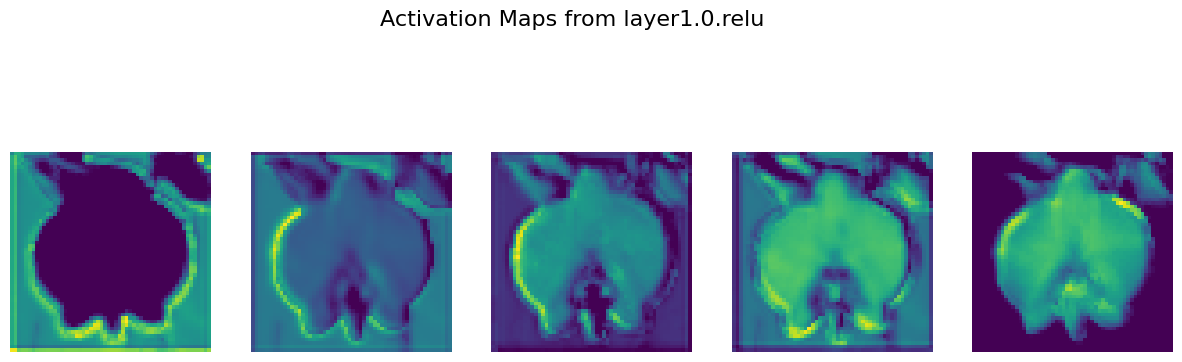

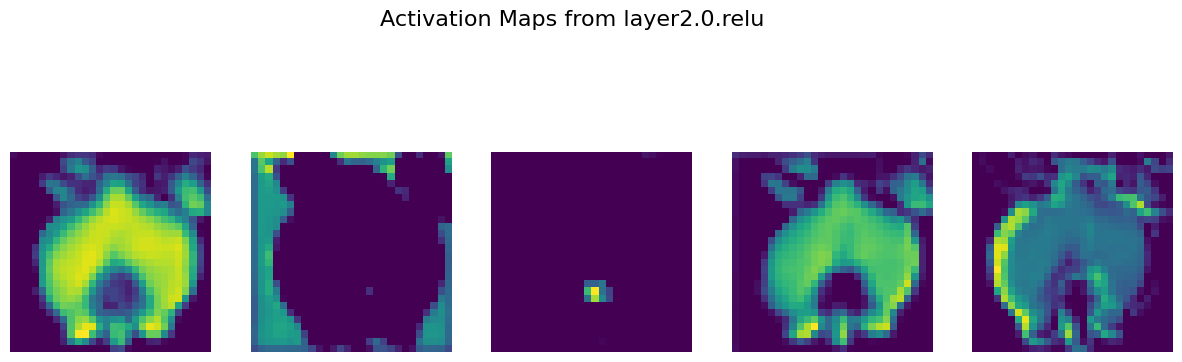

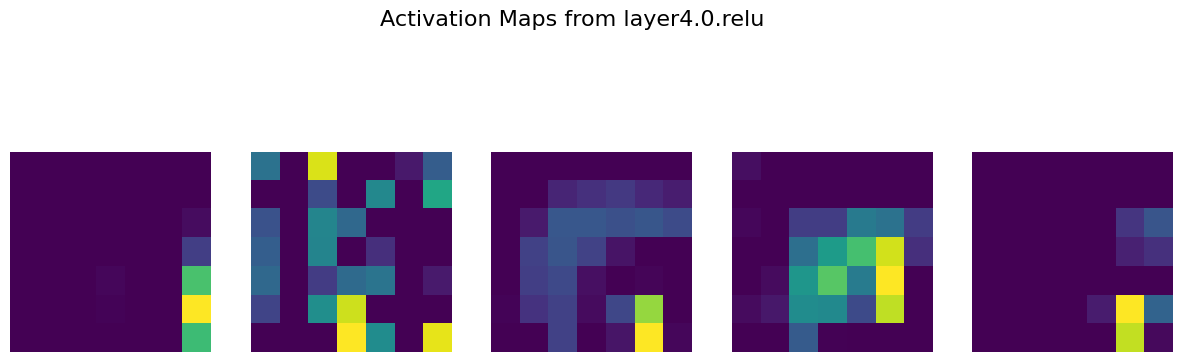

In [22]:
#activation layer outputs from selected layers after applying relu
activation_maps = {}

def get_activation_maps(name):
    def hook(model, input, output):
        activation_maps[name] = output
    return hook
    
activation_layer_names = ['layer1.0.relu', 'layer2.0.relu', 'layer4.0.relu']  
for n, l in model_res.named_modules():
    if n in activation_layer_names:
        l.register_forward_hook(get_activation_maps(n))

def visualize_activation_maps(model, image):
    model.eval()
    with torch.no_grad():
        _ = model(image.to(device))

    for layer_name, activation_map in activation_maps.items():
        activation_map = activation_map.squeeze().cpu()
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        fig.suptitle(f"Activation Maps from {layer_name}", fontsize=16)
        for i in range(5):  # Display first 5 activation maps
            axes[i].imshow(activation_map[i].numpy(), cmap='viridis')
            axes[i].axis('off')
        plt.show()

visualize_activation_maps(model_res, example_img)


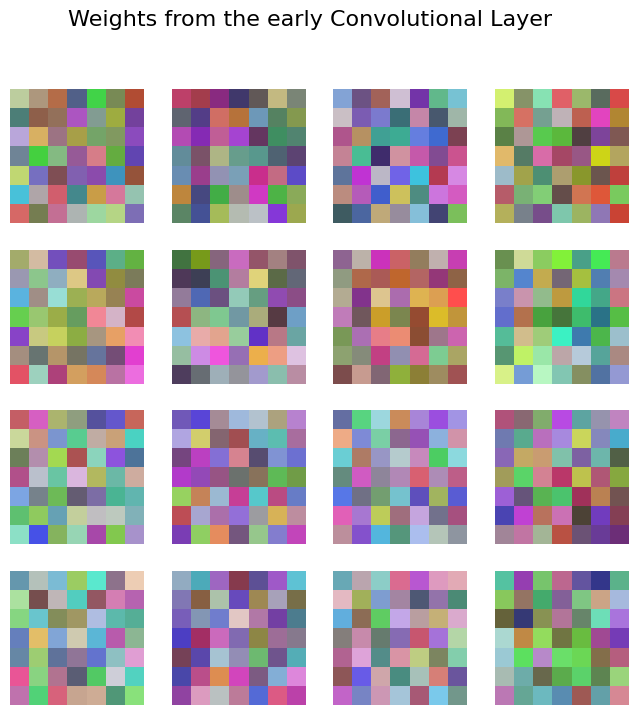

In [27]:
weights_res= model_res.conv1.weight.data.cpu()
weights_min_res= weights_res.min()
weights_max_res =weights_res.max()
normalized_weights_res = (weights_res - weights_min_res) / (weights_max_res - weights_min_res)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("Weights from the early Convolutional Layer", fontsize=16)

for i, a in enumerate(axes.flat):
    if i < normalized_weights_res.shape[0]:  
        a.imshow(normalized_weights_res[i].permute(1, 2, 0).squeeze(), cmap='cividis')
        a.axis('off')
plt.show()



In [28]:
torch.save(model_res.state_dict(), 'model_res_bonus.pth')
